This notebook will walk through the process that is used to obtain each fissioning system's correlation/covariance matrix. The script `generate.py` can be used to apply this same code to every fissioning system in the `yields` folder.

First define the fissioning system which will be analyzed (see `yields/systems.txt` for a full list of systems):

In [1]:
system = 'U235F'
Ap = 236
Zp = 92

Define constants and import packages:

In [2]:
TRIALS = 10000
import random
import numpy
import matplotlib.pyplot as plt
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

Import the yields for the selected `system`: 

In [3]:
file = open( 'yields/' + system + '.csv', 'r' )
lines = file.readlines()
file.close()
A_min = 300
A_max = 0
yields = {}
yields_unc = {}
for line in lines:
    parts = line.split(',')
    Z = int( parts[0] )
    A = int( parts[1] )
    I = int( parts[2] )
    Y = float( parts[3] )
    Y_unc = float( parts[4] )
    if( A < A_min ):
        A_min = A
    if( A > A_max ):
        A_max = A
    yields[Z,A,I] = Y
    yields_unc[Z,A,I] = Y_unc
key_list = list( yields.keys() )
key_list_Z = numpy.asarray( [sublist for sublist in key_list] ).T[0,:]
key_list_A = numpy.asarray( [sublist for sublist in key_list] ).T[1,:]
key_list.sort()

Generate a table of isomer-to-ground state ratios as these should be maintained:

In [4]:
isomer_ratios = {}
for key in yields.keys():
    if( not( (key[0],key[1]) in isomer_ratios.keys() ) ):
        ratios = [ 0.0, 0.0, 0.0 ]
        for key2 in yields.keys():
            if( (key2[0] == key[0]) and (key2[1] == key[1]) ):
                ratios[ key2[2] ] = yields[key2]

        norm = 1.0 / sum(ratios)
        for i in range(0,2):
            ratios[i] = norm * ratios[i]

        isomer_ratios[key[0],key[1]] = ratios

Read in the $P(\nu,A)$ distribution for the system:

In [5]:
file = open( 'yields/P_nu_A/' + system + '_nu_data.csv', 'r' )
lines = file.readlines()
file.close()
P_nu_A = {}
for line in lines:
    parts = line.split(',')
    A = int( parts[0] )
    P_nu = []
    for part in parts[1:]:
        P_nu.append( float( part ) )
    #Ensure normalization
    #-------------------------------------------------------------------------------------
    norm = 1.0 / sum( P_nu )
    for i in range(0,len(P_nu)):
        P_nu[i] = norm * P_nu[i]
    #-------------------------------------------------------------------------------------
    P_nu_A[A] = P_nu

nu_bar = 0.0
for key in key_list:
    for i in range(0,10):
        nu_bar += P_nu_A[key[1]][i] * i * yields[key]/200.0

Calculate the middle A chain of the system. This should be the A that get closest to yielding one half of the distribution having yields that sum to 1:

In [6]:
A_mid = None
Y_tot = 0.0
for A in range(A_min,A_max):
    for Z in range(0,100):
        for I in range(0,3):
            try:
                Y_tot += yields[Z,A,I]
            except KeyError as e:
                pass
    if( Y_tot >= 100.0 ):
        A_mid = A
        break

Perform `n = TRIALS` of resamplings of fission yield library (read comments for substep details):

In [7]:
numpy.random.seed(0)
random.seed(0)
trials_res = numpy.zeros( (len(key_list),TRIALS) )
for n in range(0,TRIALS):
    yields_vard = {}

    #Sample whether to resample from the heavy or light side
    #-------------------------------------------------------------------------------------
    side = random.random()

    if( side < 0.5 ): #light side to be resampled
        As = list( range( A_min, A_mid ) )
        As2 = list( range( A_mid, A_max+1 ) )
    else: #heavy side to be resampled
        As = list( range( A_mid, A_max+1 ) )
        As2 = list( range( A_min, A_mid ) )
    #-------------------------------------------------------------------------------------



    #Resample yields on side
    #Go along each A in As, selected a Z in a weighted fashion
    #Increase all yields along the A chain by the percent A,Z was increased
    #-------------------------------------------------------------------------------------
    for A in As:
        #Get keys with this A 
        #---------------------------------------------------------------------------------
        keys = []
        for key in yields.keys():
            if( key[1] == A ):
                keys.append( key )
        #---------------------------------------------------------------------------------



        #Choose which yield will be resampled
        #---------------------------------------------------------------------------------
        weights = []
        for key in keys:
            weights.append( 1.0 / yields_unc[key] )
        weights = numpy.array( weights ) / sum(weights)

        selected = numpy.random.choice( list(range(0,len(keys))), p=weights )
        selected = keys[ selected ]
        #---------------------------------------------------------------------------------



        #Sample selected yield and scale all yields in A chain up by the same percentage
        #---------------------------------------------------------------------------------
        Y_vard = numpy.random.normal( yields[selected], yields_unc[selected] )
        while( Y_vard <= 0.0 ):
            Y_vard = numpy.random.normal( yields[selected], yields_unc[selected] )

        percent_shift = Y_vard / yields[selected]

        for key in keys:
            # if( key == (54,141,0) ):
            # 	print( percent_shift * yields[key], yields[key] )
            yields_vard[key] = percent_shift * yields[key]
        #---------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------


    #Normalize yields that were resampled from one side to sum to 1.0
    #-------------------------------------------------------------------------------------
    norm = 0.0
    for key in yields_vard.keys():
        norm += yields_vard[key]
    norm = 100.0 / norm

    for key in yields_vard.keys():
        yields_vard[key] = norm * yields_vard[key]
    #-------------------------------------------------------------------------------------


    #Use he P(nu,A) distribution to calculate yields on the other side of the distribution
    #-------------------------------------------------------------------------------------
    for key in list( yields_vard.keys() ):
        Z_comp =  Zp - key[0]
        P_nu = P_nu_A[key[1]][:]
        nus = list( range(0,len(P_nu)) )
        #Check if each nu P_nu leads to an existing isotope in the evaluation
        #If not remove that nu from P_nu and renormalize P_nu
        #---------------------------------------------------------------------------------
        for nu in range(len(P_nu)-1,-1,-1):
            A_comp = Ap - nu - key[1]
            if( not( (Z_comp,A_comp) in isomer_ratios.keys() ) ):
                del nus[nu]
                del P_nu[nu]

        if( (len(nus) == 0) or (sum(P_nu) == 0) ):
            continue

        norm = 1.0 / sum(P_nu)
        for i in range(0,len(P_nu)):
            P_nu[i] = norm * P_nu[i]
        #---------------------------------------------------------------------------------



        #Calculate partial yields
        #---------------------------------------------------------------------------------
        for j in range(0,len(nus)):
            nu = nus[j]
            A_comp = Ap - nu - key[1]
            for i in range(0,2):
                Y = yields_vard[key] * P_nu[j] * isomer_ratios[Z_comp, A_comp][i]
                try:
                    yields_vard[Z_comp,A_comp,i] += Y
                except KeyError as e:
                    yields_vard[Z_comp,A_comp,i] = Y
        #---------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------


    #Place resampled yields into a numpy array for rapid covariance matrix calculation
    #-------------------------------------------------------------------------------------
    for i in range(0,len(key_list)):
        key = key_list[i]
        try:
            trials_res[i,n] = yields_vard[key]
        except KeyError as e:
            trials_res[i,n] = yields[key]
    #-------------------------------------------------------------------------------------

Verify that the five quantities are indeed conserved: 

In [8]:
YZs_ratio_cuts = []
file = open( 'matrices/verification_records/verification_' + system + '.csv', 'w' )
file.write( 'Y_tot/200, Z_tot/Z_CN, A_tot/(A_CN-nu_bar), min( abs(Y(Z)/Y(Z_CN-Z) - 1) ), avg( abs(Y(Z)/Y(Z_CN-Z) ) ) \n' )
for n in range(0,TRIALS):
    Y_tot = sum( trials_res[:,n] ) / 200.0
    Z_tot = sum( trials_res[:,n] * key_list_Z ) / (Zp*Y_tot*100.0)
    A_tot = sum( trials_res[:,n] * key_list_A ) / ((Ap-nu_bar)*Y_tot*100.0)
    YZs = numpy.zeros( 300 )
    for i in range(0,len(key_list)):
        YZs[ key_list[i][0] ] += trials_res[i,n]

    YZs_ratio = []
    for i in range(min(key_list_Z),max(key_list_Z)+1):
        YZs_ratio.append( YZs[i]/YZs[Zp-i] )
        YZs_ratio_cuts.append( YZs[i]/YZs[Zp-i] )
    YZs_ratio = numpy.array( YZs_ratio ) 
    YZs_ratio_cut = YZs_ratio[abs(YZs_ratio - numpy.mean(YZs_ratio)) < 5 * numpy.std(YZs_ratio)]
    avg = numpy.mean( YZs_ratio_cut )
    file.write( str(Y_tot) + ', ' + str(Z_tot) + ', ' + str(A_tot) + ', ' + str(min(abs(YZs_ratio-1.0))) + ', ' + str(avg) + '\n' )
file.close()
YZs_ratio_cuts = numpy.array( YZs_ratio_cuts )
n_start = len(YZs_ratio_cuts)
#YZs_ratio_cuts = YZs_ratio_cuts[abs(YZs_ratio_cuts - numpy.mean(YZs_ratio_cuts)) < 3 * numpy.std(YZs_ratio_cuts)]
YZs_ratio_cuts = YZs_ratio_cuts[ abs(YZs_ratio_cuts - 1.0) < 1.0 ]
rcParams['figure.figsize'] = 8, 8
plt.hist( YZs_ratio_cuts, bins=100 )
plt.xlabel( 'abs(Y(Z)/Y(Z_CN-Z)' )
plt.ylabel( 'No. Occurrances' )
plt.title( str(len(YZs_ratio_cuts)) + '/' + str(n_start)  + ', ' + str( round(numpy.mean(YZs_ratio_cuts),4) ) )
plt.tight_layout()
plt.savefig( 'matrices/verification_records/verification_' + system + '.png' )
plt.clf()

<Figure size 576x576 with 0 Axes>

Calculate the covariance and correlation matrices:

In [9]:
yields_corr = numpy.corrcoef( trials_res )
df_std = []
df_stdT = []
for key in key_list:
    df_std.append( yields_unc[key] )
    df_stdT.append( [yields_unc[key]] )
df_std = numpy.array( df_std )
df_stdT = numpy.array( df_stdT )
yields_cov = df_std * yields_corr * df_stdT

Plot the correlation matrix:

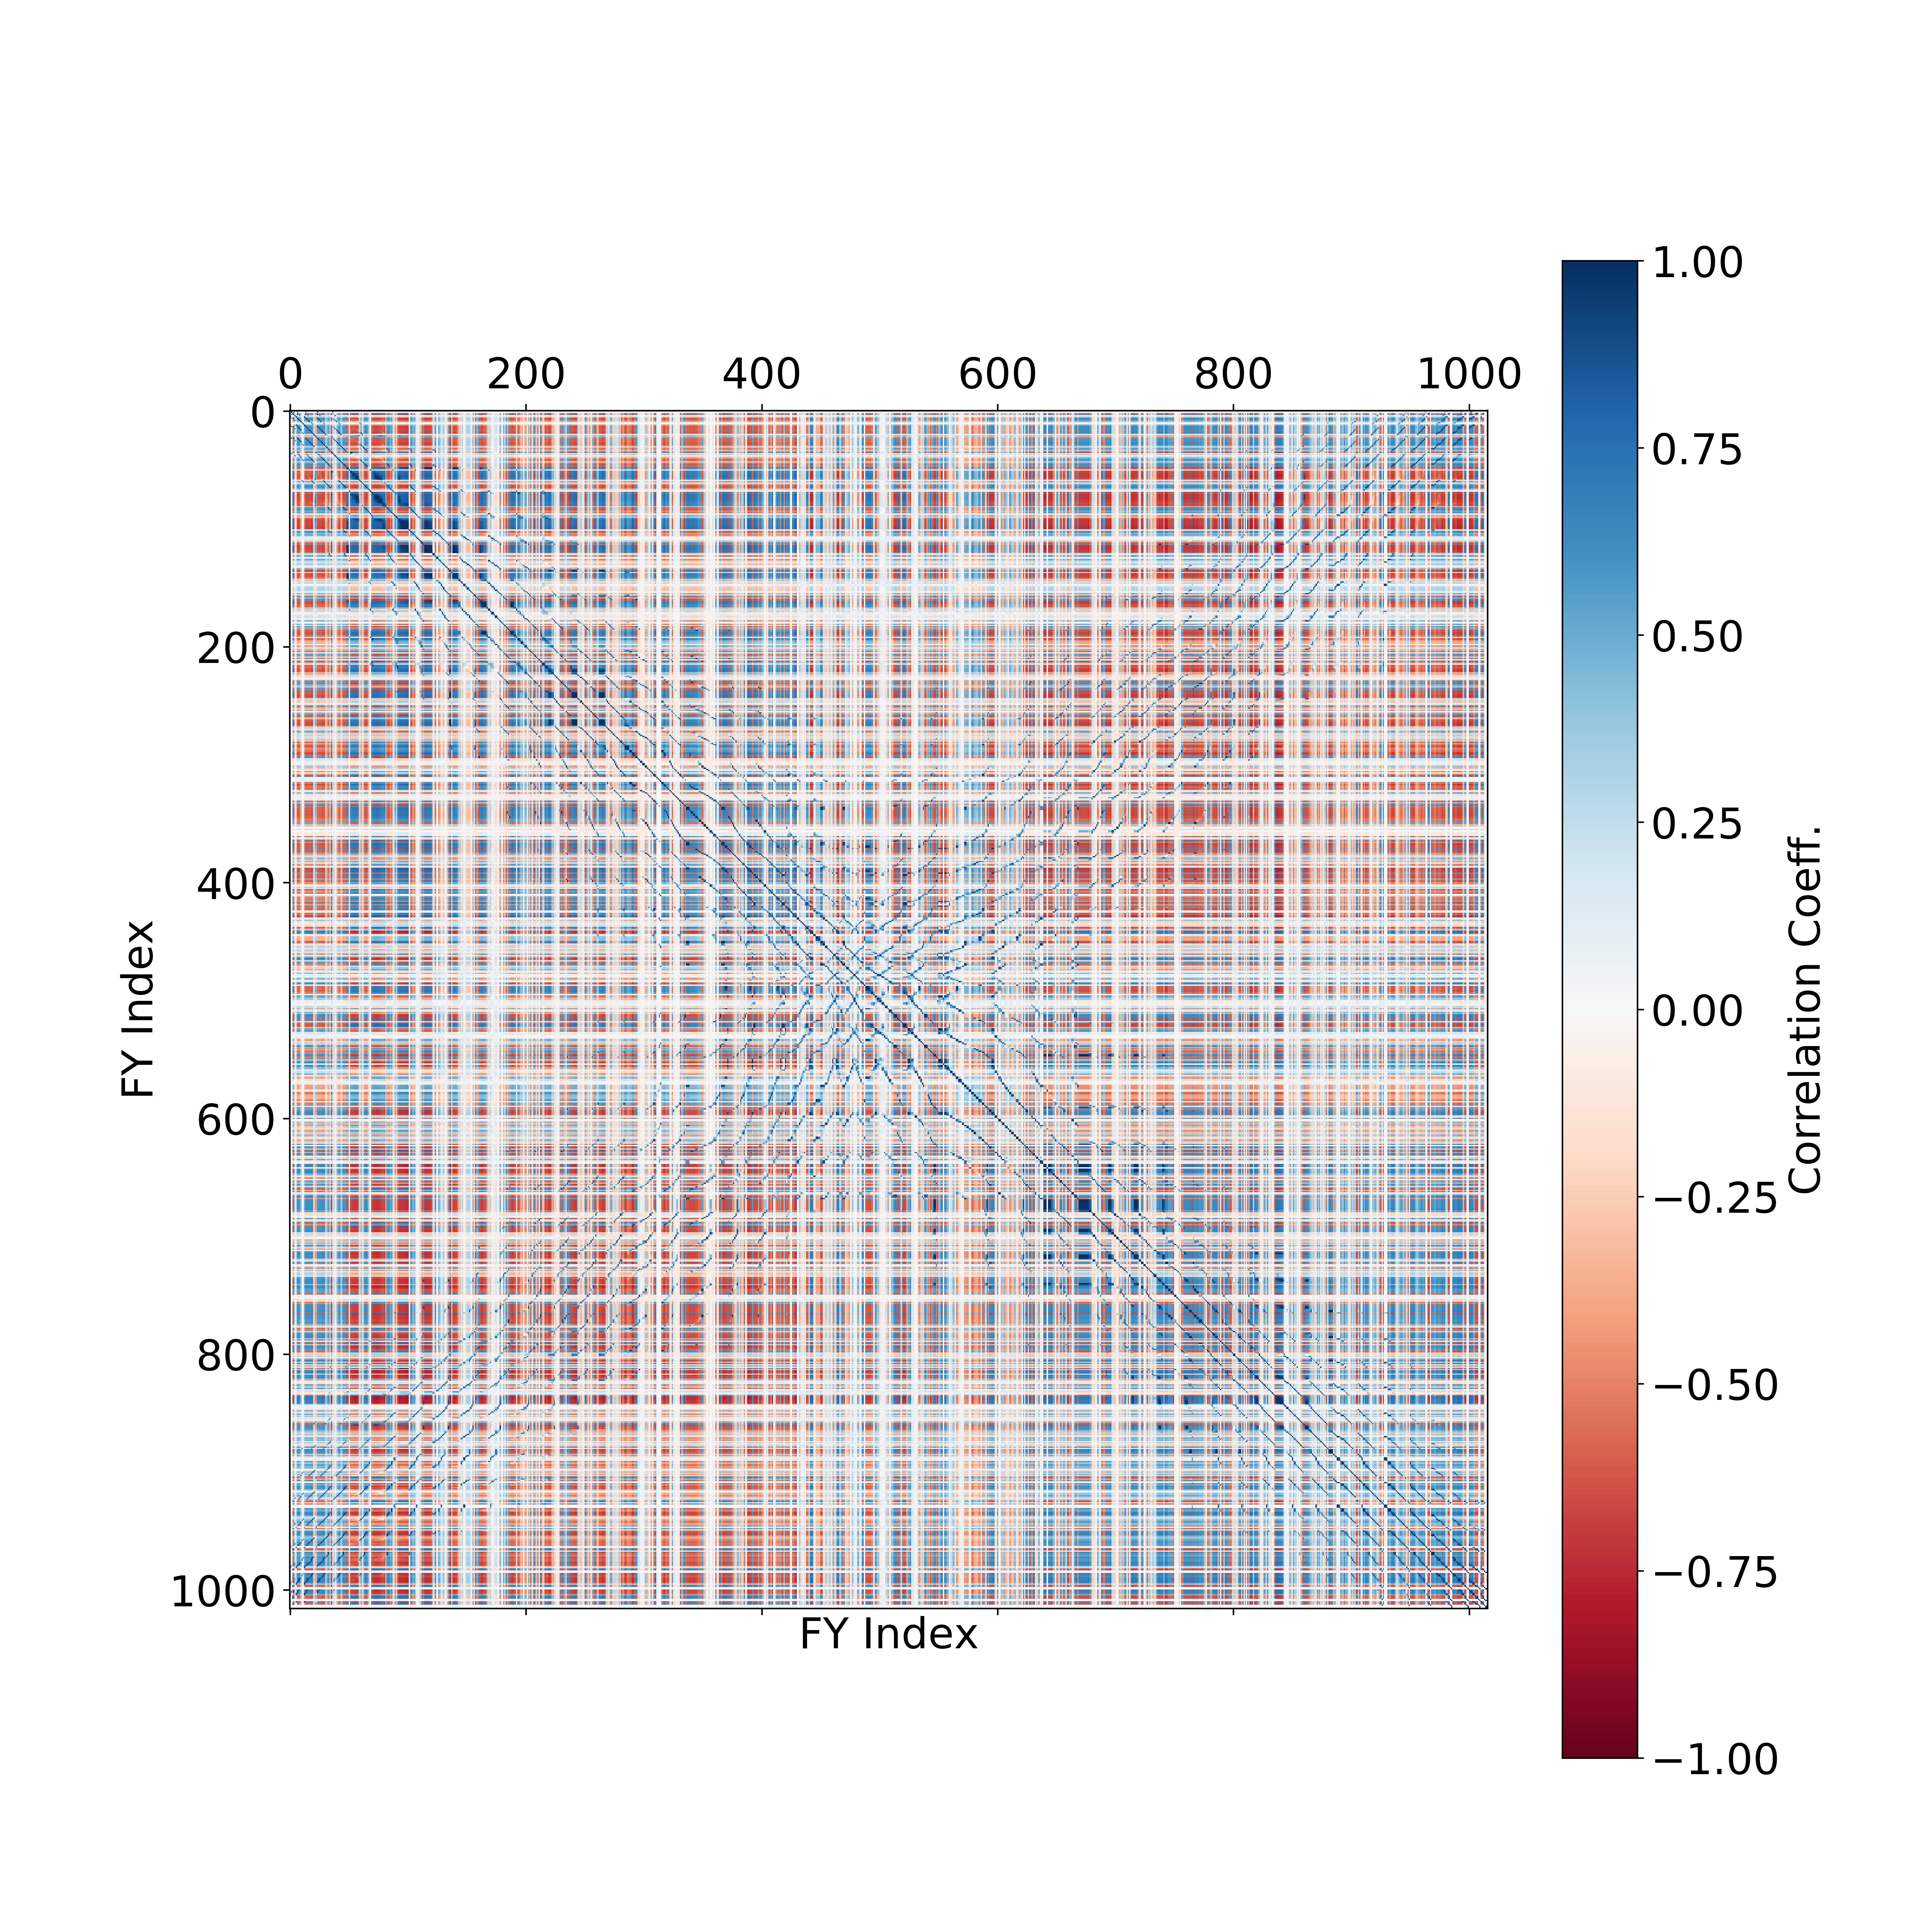

<Figure size 1008x1008 with 0 Axes>

In [10]:
rcParams['figure.figsize'] = 14, 14
rcParams['font.size'] = 22
plt.matshow(yields_corr,cmap="RdBu",vmin=-1.0,vmax=1.0)
cbar = plt.colorbar()
cbar.set_label('Correlation Coeff.')
plt.tight_layout()
plt.xlabel('FY Index')
plt.ylabel('FY Index')
plt.savefig( 'figures/' + system + '_corr.eps', format='eps', dpi=300 )
plt.savefig( 'figures/' + system + '_corr.png', dpi=500 )
plt.clf()
Image( 'figures/' + system + '_corr.png' )

Plot the covariance between a choice product and all the other products:

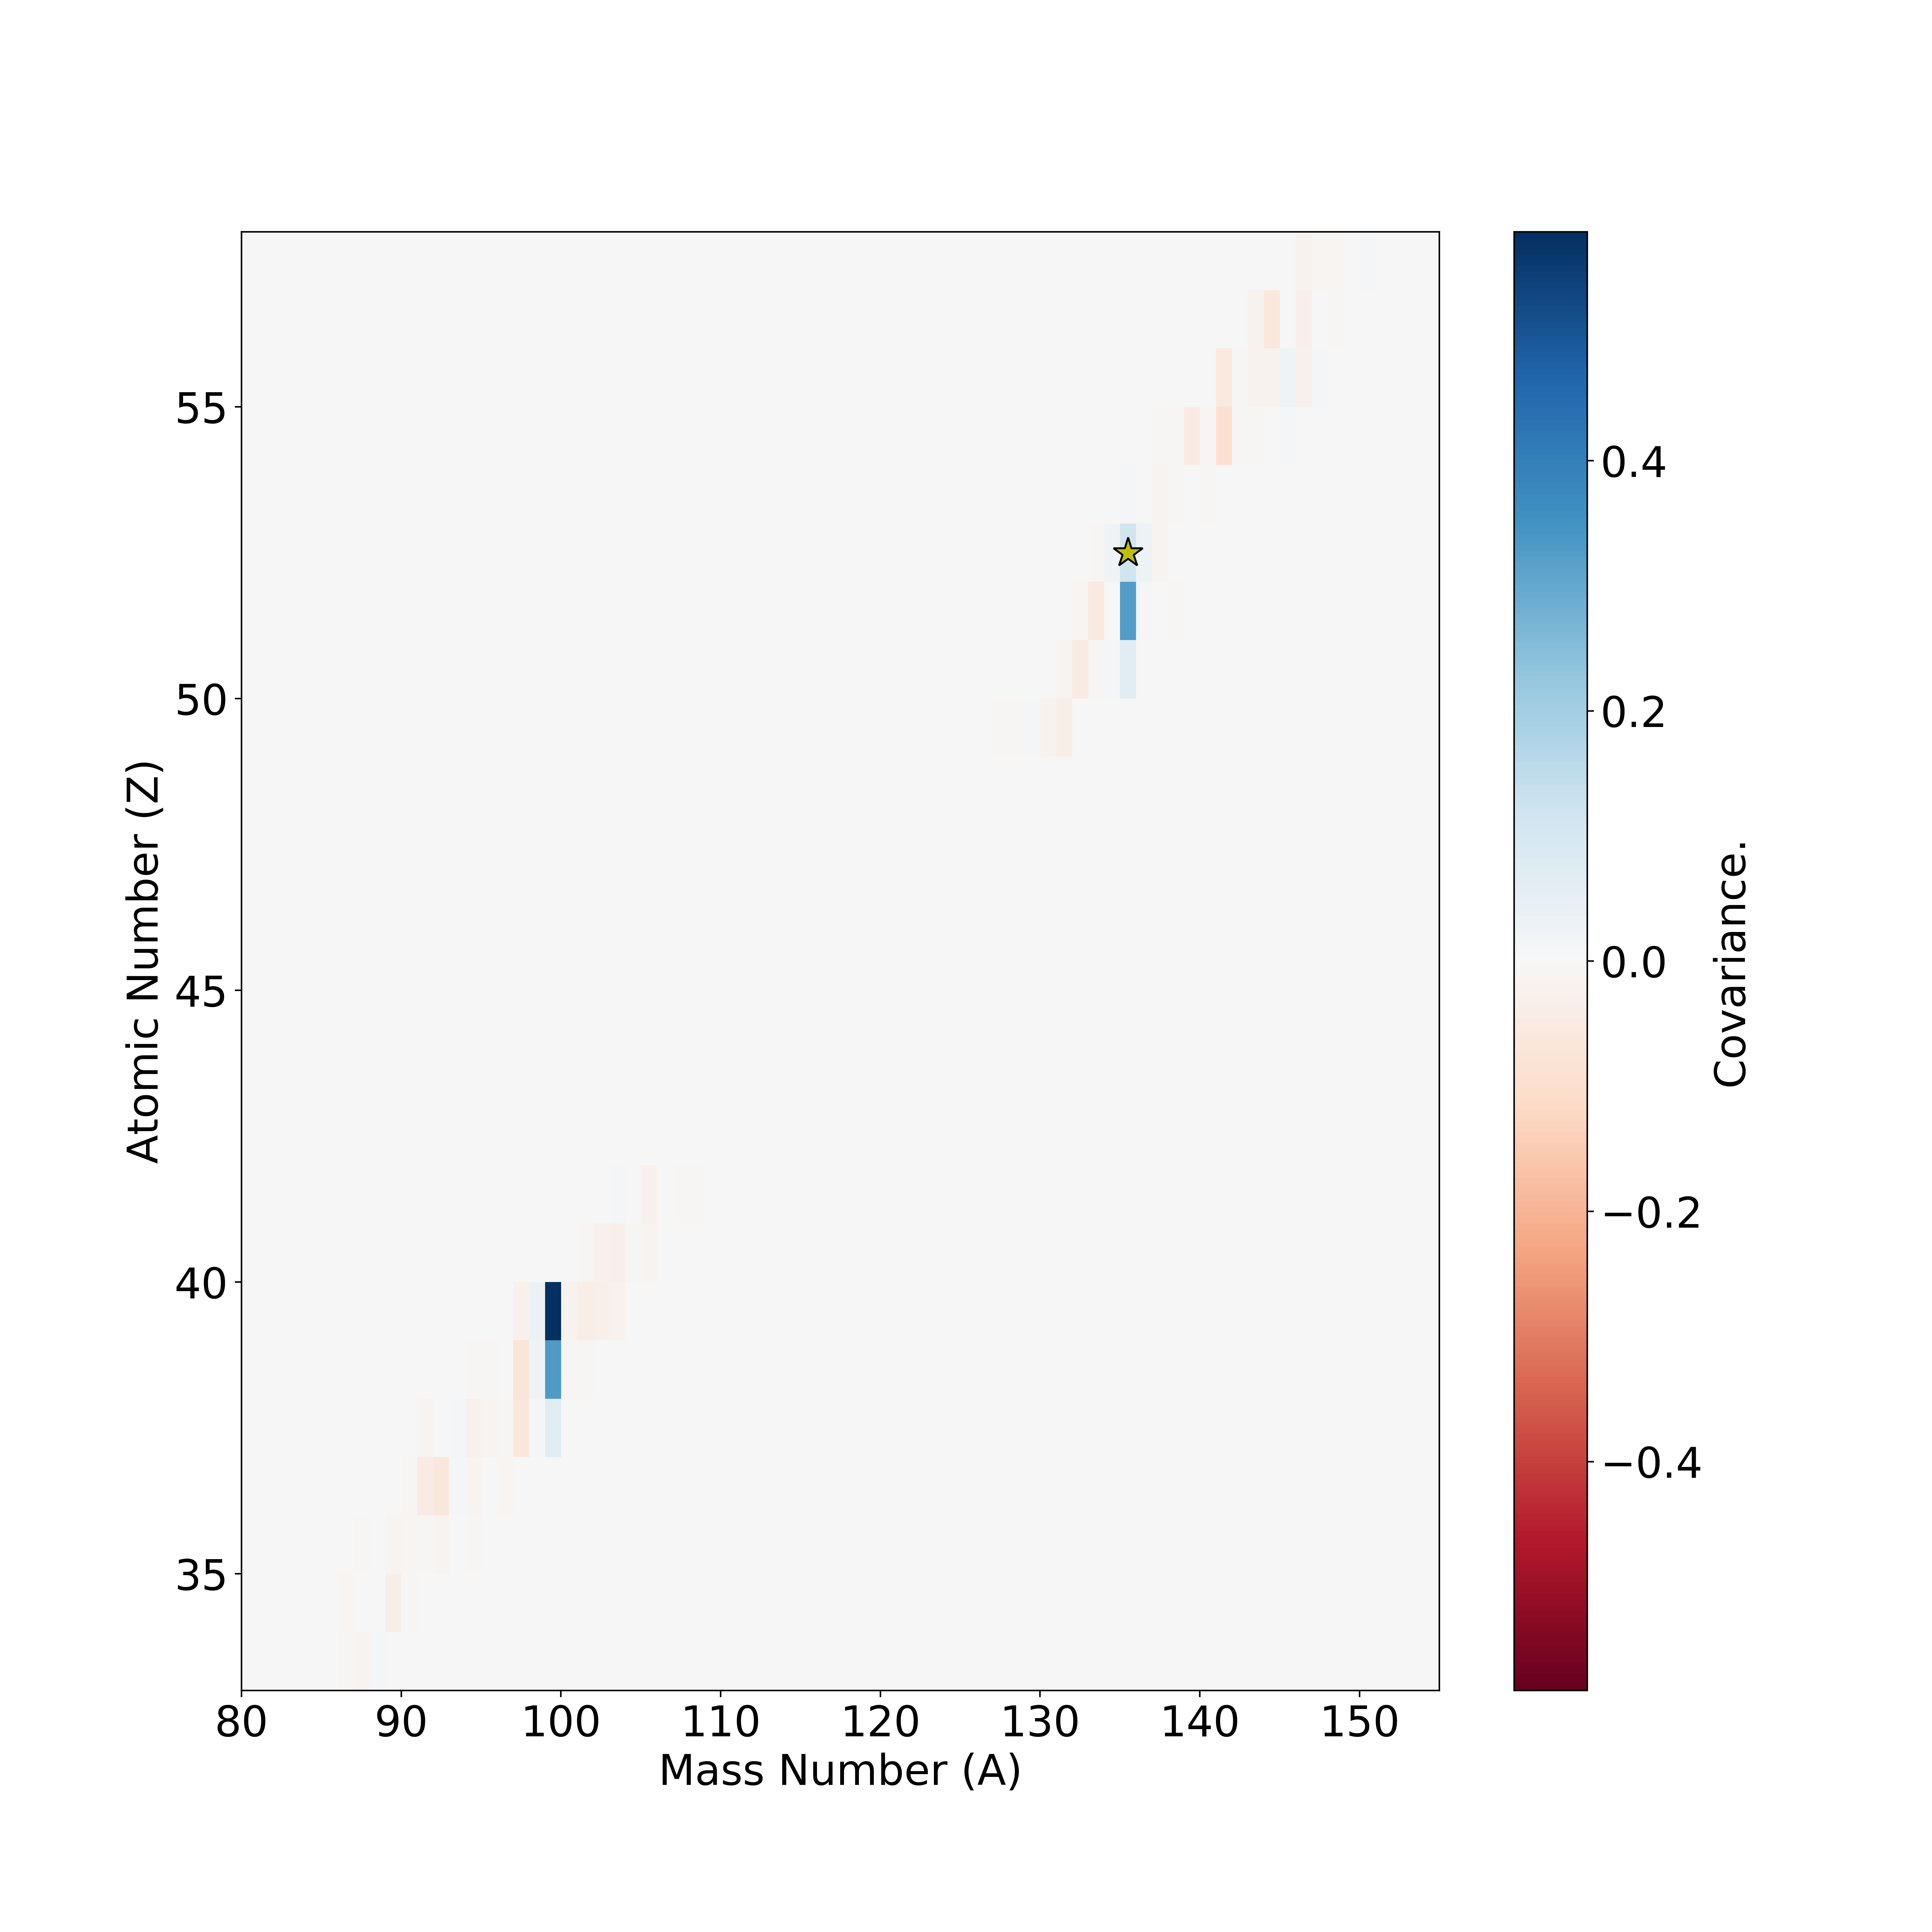

<Figure size 1008x1008 with 0 Axes>

In [11]:
choice = (52,135,0)
choice_ind = key_list.index( choice )
covs = numpy.zeros( (300,300) )
for key in key_list:
    if( key[2] != 0 ): #skip isomers, correlations should be identical because ratios are same
        continue
    ind_cur = key_list.index( key )
    covs[ 300-key[0], key[1] ] = yields_cov[ choice_ind, ind_cur ]


rcParams['figure.figsize'] = 14, 14
rcParams['font.size'] = 22
maxval = numpy.max( numpy.abs( covs ) )
plt.imshow(covs,cmap="RdBu",extent=(0,300,0,300),vmin=-maxval,vmax=maxval)
plt.plot( [choice[1]+0.5], [choice[0]+0.5], 'y*', markersize=16, markeredgecolor='k' )
cbar = plt.colorbar()
cbar.set_label('Covariance.')
plt.axis( [80,155,33,58] )
plt.axes().set_aspect('auto')
plt.ylabel('Atomic Number (Z)')
plt.xlabel('Mass Number (A)')
plt.savefig( 'figures/ZA_example_cov.eps', format='eps', dpi=300 )
plt.savefig( 'figures/ZA_example_cov.png', dpi=500 )
plt.clf()
Image( 'figures/ZA_example_cov.png' )

Plot the resampled distribution for a particular product:

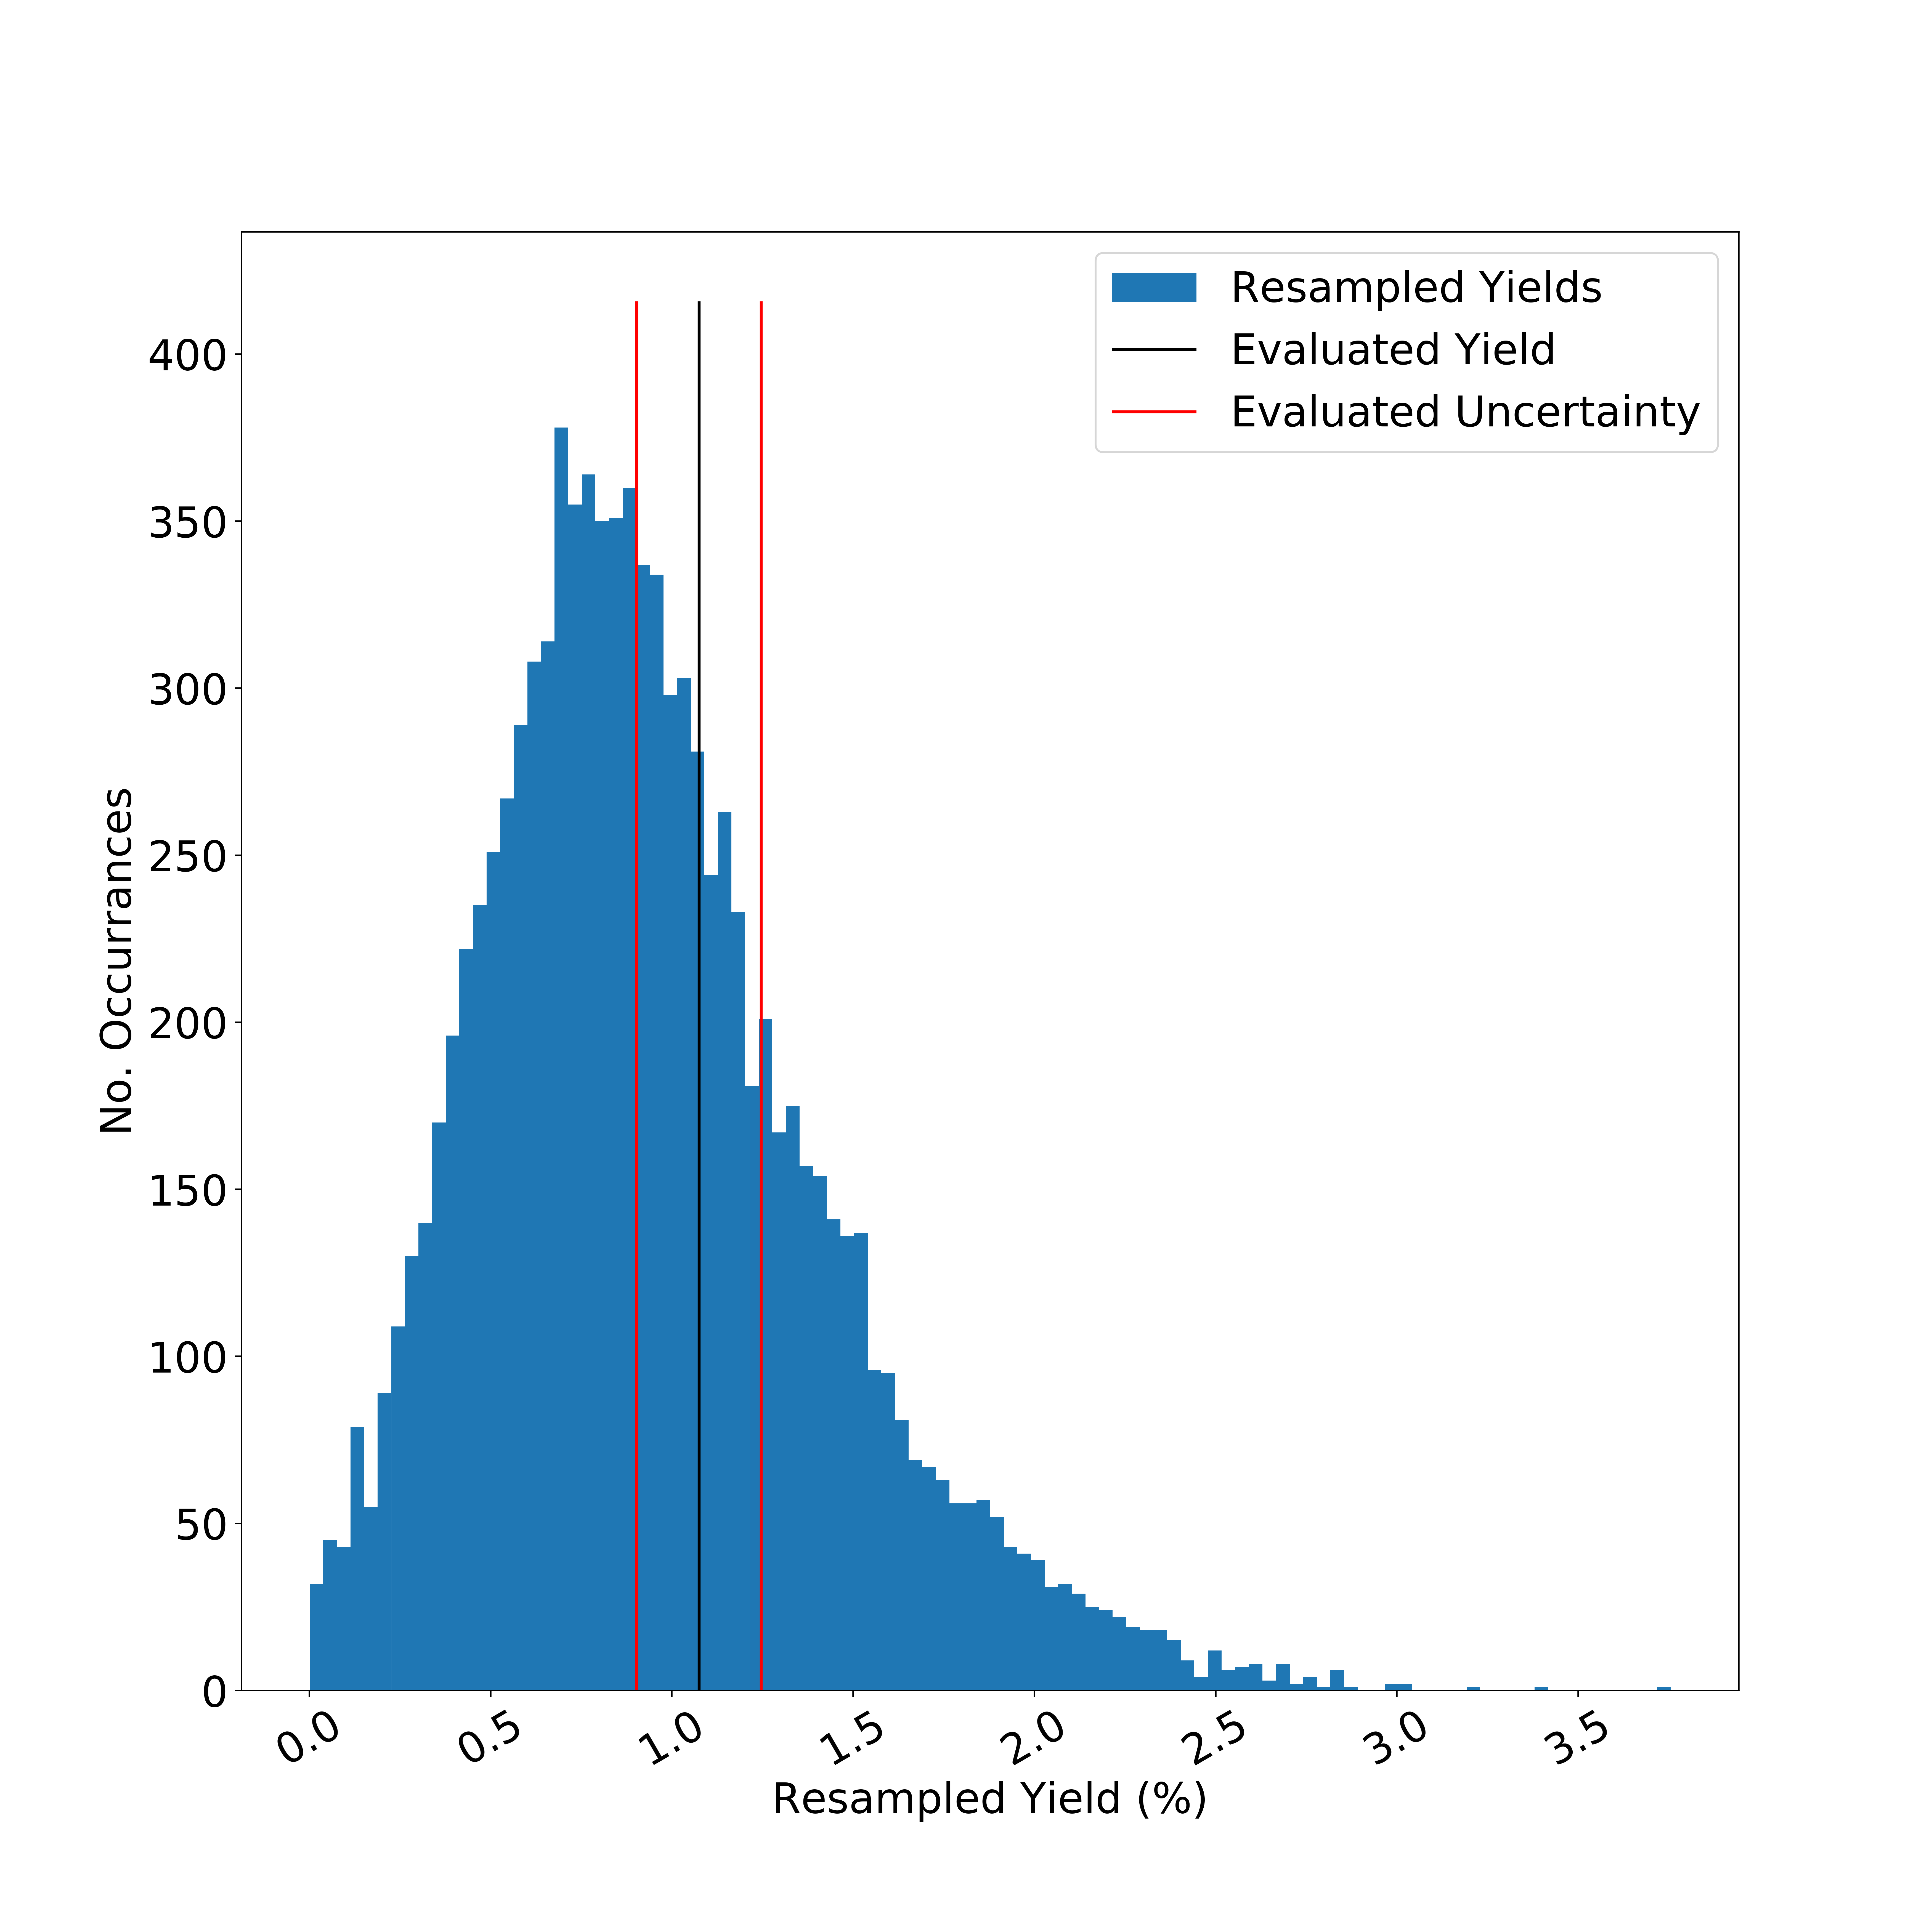

<Figure size 1008x1008 with 0 Axes>

In [12]:
key = (52,132,0)
ind = key_list.index( key )
resampled = trials_res[ind,:]
vals = plt.hist(resampled,bins=100,label='Resampled Yields')
h_max = 1.1*max(vals[0])
plt.vlines(yields[key],0,h_max,color='k',label='Evaluated Yield')
plt.vlines([yields[key]-yields_unc[key],yields[key]+yields_unc[key]],0,h_max,color='r',label='Evaluated Uncertainty')
plt.xlabel('Resampled Yield (%)')
plt.ylabel('No. Occurrances')
plt.xticks(rotation=30)
plt.legend()
plt.savefig( 'figures/distributions/hist' + str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '.eps', format='eps' )
plt.savefig( 'figures/distributions/hist' + str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '.png', dpi=500 )
plt.clf()
Image( 'figures/distributions/hist' + str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '.png' )

Now recalculate this covariance matrix with a simplistic choice of $P(\nu)$:

In [13]:
P_nu = [ 0.0216, 0.163, 0.304, 0.326, 0.153, 0.039, 0.001, 0.0, 0.0, 0.0 ]
norm = sum(P_nu)
for i in range(0,len(P_nu)):
	P_nu[i] = P_nu[i] / norm

P_nu_A = {}
for A in range(A_min,A_max+1):
    P_nu_A[A] = P_nu[:]

Run the trials:

In [14]:
numpy.random.seed(0)
random.seed(0)
trials_res = numpy.zeros( (len(key_list),TRIALS) )
for n in range(0,TRIALS):
    yields_vard = {}

    #Sample whether to resample from the heavy or light side
    #-------------------------------------------------------------------------------------
    side = random.random()

    if( side < 0.5 ): #light side to be resampled
        As = list( range( A_min, A_mid ) )
        As2 = list( range( A_mid, A_max+1 ) )
    else: #heavy side to be resampled
        As = list( range( A_mid, A_max+1 ) )
        As2 = list( range( A_min, A_mid ) )
    #-------------------------------------------------------------------------------------



    #Resample yields on side
    #Go along each A in As, selected a Z in a weighted fashion
    #Increase all yields along the A chain by the percent A,Z was increased
    #-------------------------------------------------------------------------------------
    for A in As:
        #Get keys with this A 
        #---------------------------------------------------------------------------------
        keys = []
        for key in yields.keys():
            if( key[1] == A ):
                keys.append( key )
        #---------------------------------------------------------------------------------



        #Choose which yield will be resampled
        #---------------------------------------------------------------------------------
        weights = []
        for key in keys:
            weights.append( 1.0 / yields_unc[key] )
        weights = numpy.array( weights ) / sum(weights)

        selected = numpy.random.choice( list(range(0,len(keys))), p=weights )
        selected = keys[ selected ]
        #---------------------------------------------------------------------------------



        #Sample selected yield and scale all yields in A chain up by the same percentage
        #---------------------------------------------------------------------------------
        Y_vard = numpy.random.normal( yields[selected], yields_unc[selected] )
        while( Y_vard <= 0.0 ):
            Y_vard = numpy.random.normal( yields[selected], yields_unc[selected] )

        percent_shift = Y_vard / yields[selected]

        for key in keys:
            # if( key == (54,141,0) ):
            # 	print( percent_shift * yields[key], yields[key] )
            yields_vard[key] = percent_shift * yields[key]
        #---------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------


    #Normalize yields that were resampled from one side to sum to 1.0
    #-------------------------------------------------------------------------------------
    norm = 0.0
    for key in yields_vard.keys():
        norm += yields_vard[key]
    norm = 100.0 / norm

    for key in yields_vard.keys():
        yields_vard[key] = norm * yields_vard[key]
    #-------------------------------------------------------------------------------------


    #Use he P(nu,A) distribution to calculate yields on the other side of the distribution
    #-------------------------------------------------------------------------------------
    for key in list( yields_vard.keys() ):
        Z_comp =  Zp - key[0]
        P_nu = P_nu_A[key[1]][:]
        nus = list( range(0,len(P_nu)) )
        #Check if each nu P_nu leads to an existing isotope in the evaluation
        #If not remove that nu from P_nu and renormalize P_nu
        #---------------------------------------------------------------------------------
        for nu in range(len(P_nu)-1,-1,-1):
            A_comp = Ap - nu - key[1]
            if( not( (Z_comp,A_comp) in isomer_ratios.keys() ) ):
                del nus[nu]
                del P_nu[nu]

        if( (len(nus) == 0) or (sum(P_nu) == 0) ):
            continue

        norm = 1.0 / sum(P_nu)
        for i in range(0,len(P_nu)):
            P_nu[i] = norm * P_nu[i]
        #---------------------------------------------------------------------------------



        #Calculate partial yields
        #---------------------------------------------------------------------------------
        for j in range(0,len(nus)):
            nu = nus[j]
            A_comp = Ap - nu - key[1]
            for i in range(0,2):
                Y = yields_vard[key] * P_nu[j] * isomer_ratios[Z_comp, A_comp][i]
                try:
                    yields_vard[Z_comp,A_comp,i] += Y
                except KeyError as e:
                    yields_vard[Z_comp,A_comp,i] = Y
        #---------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------


    #Place resampled yields into a numpy array for rapid covariance matrix calculation
    #-------------------------------------------------------------------------------------
    for i in range(0,len(key_list)):
        key = key_list[i]
        try:
            trials_res[i,n] = yields_vard[key]
        except KeyError as e:
            trials_res[i,n] = yields[key]
    #-------------------------------------------------------------------------------------

Replot the resampled distribution for a particular product:

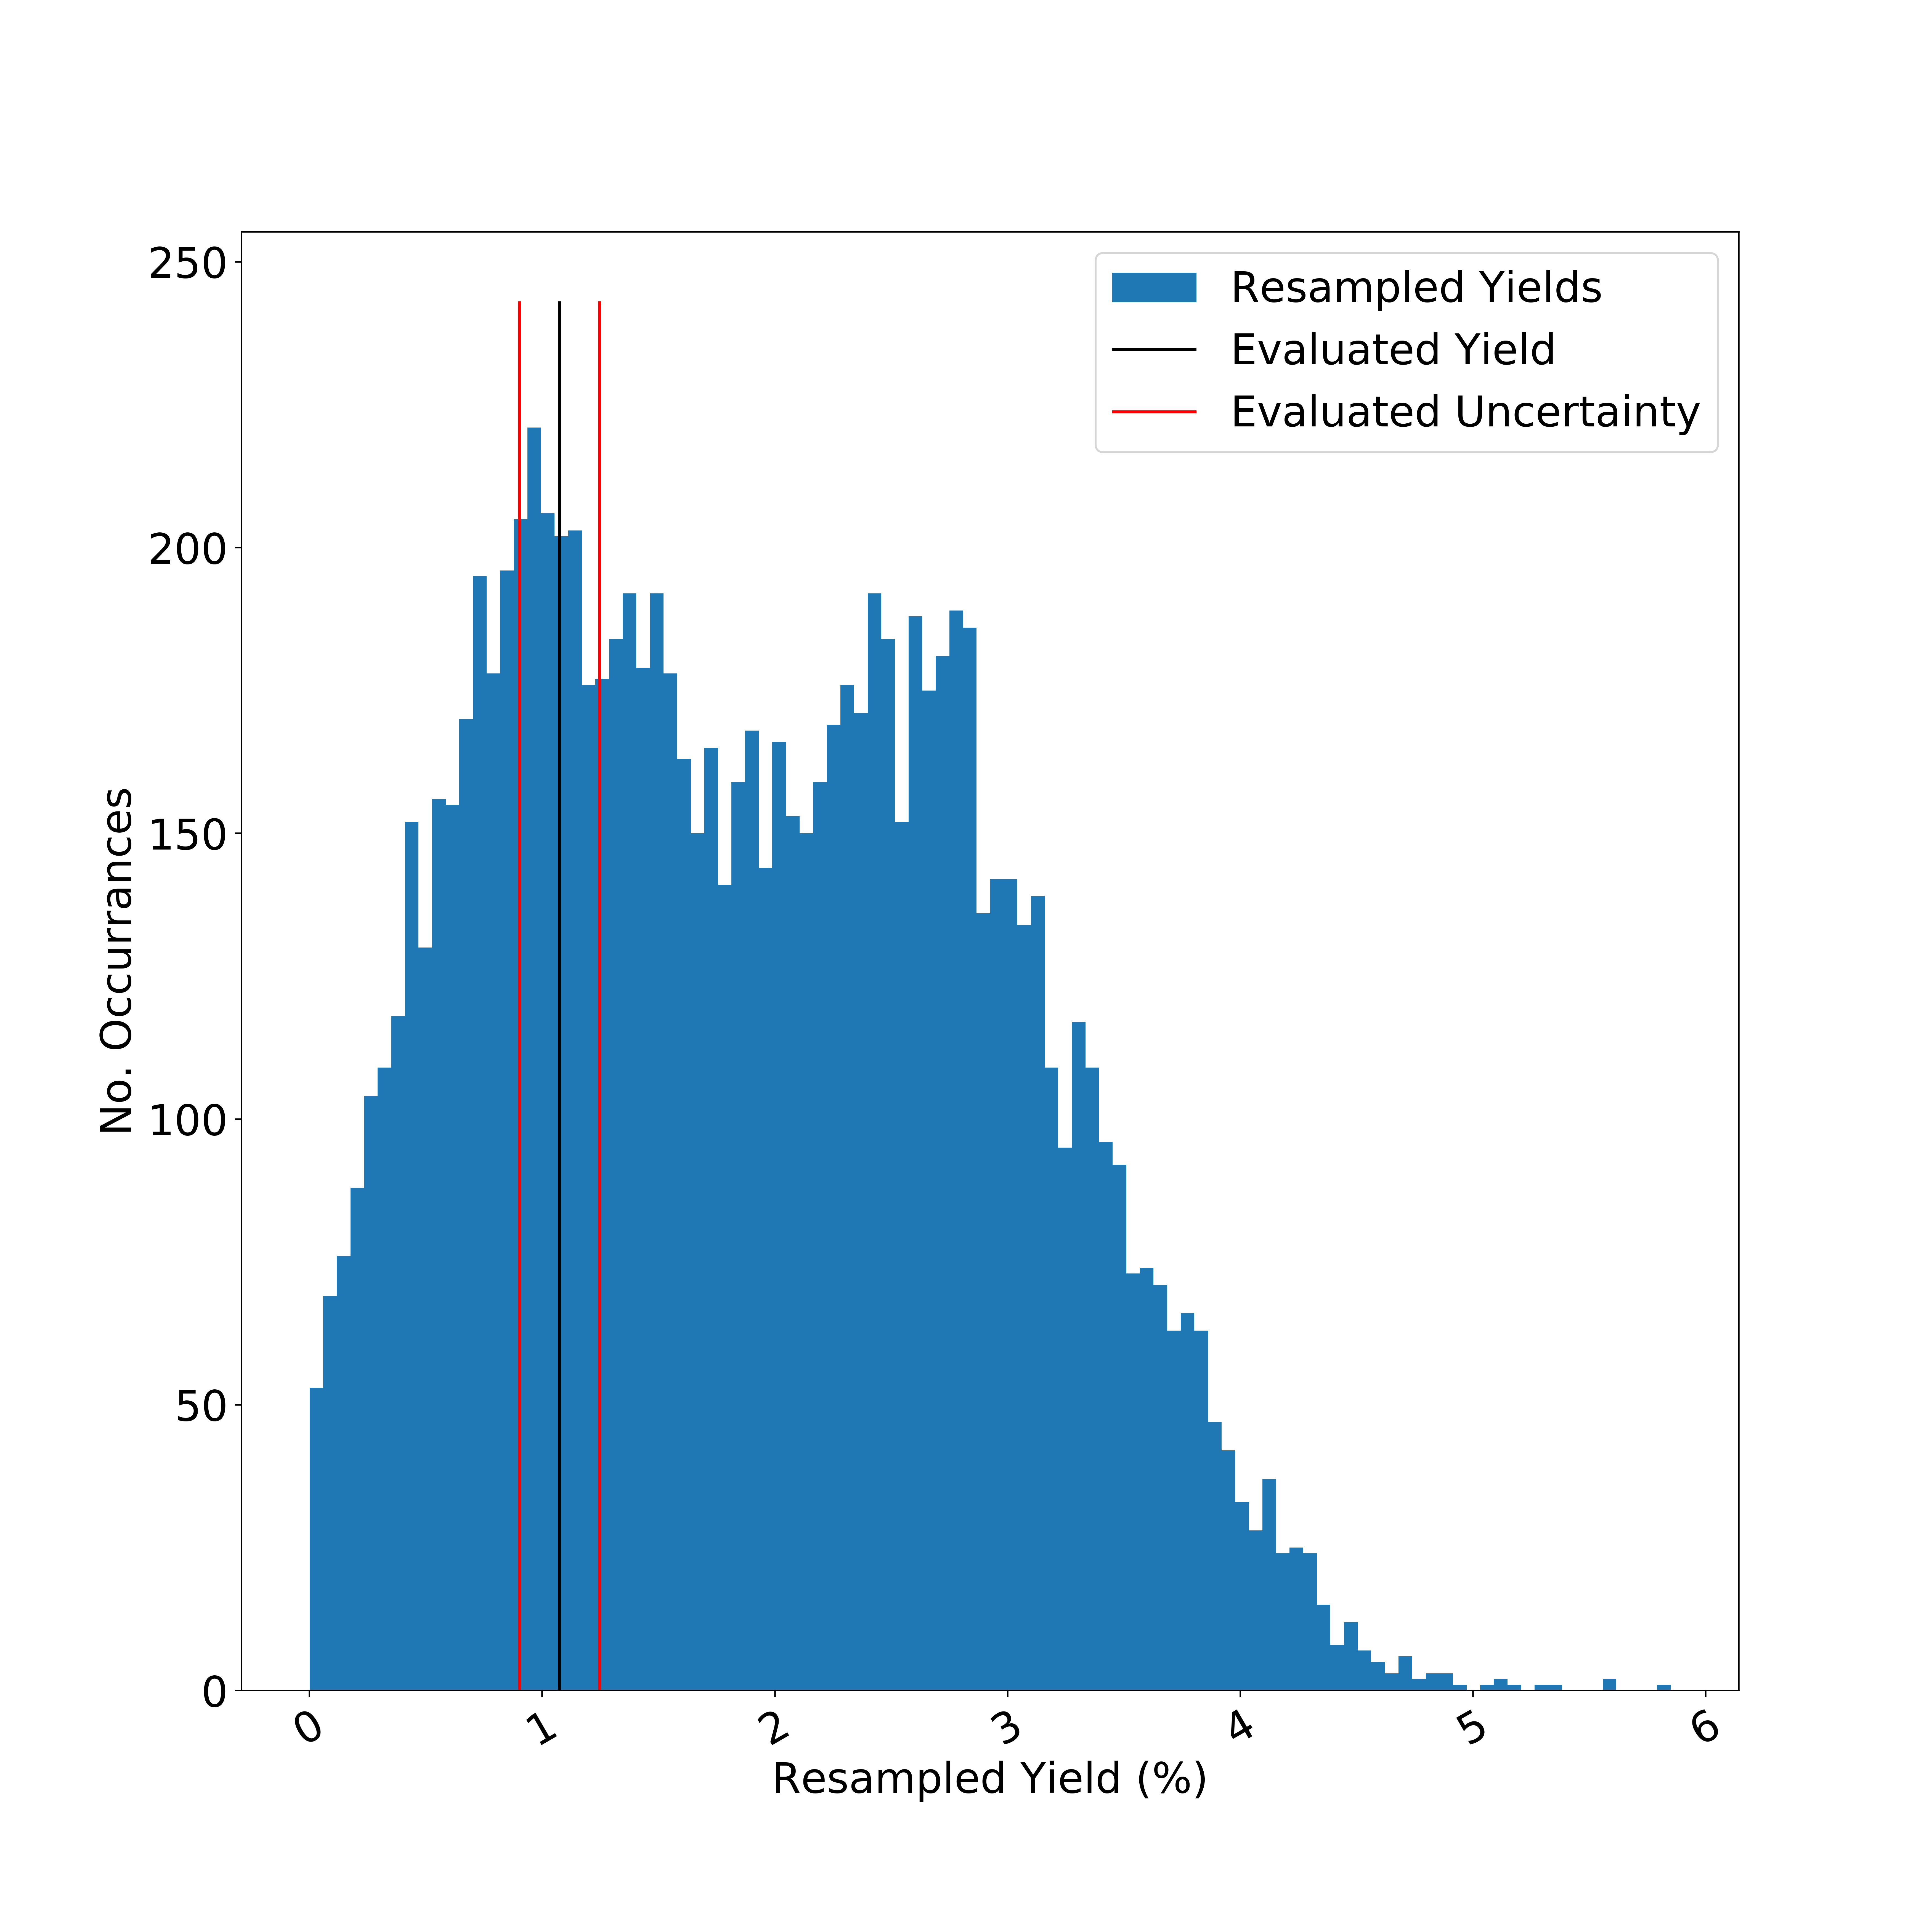

<Figure size 1008x1008 with 0 Axes>

In [15]:
key = (52,132,0)
ind = key_list.index( key )
resampled = trials_res[ind,:]
vals = plt.hist(resampled,bins=100,label='Resampled Yields')
h_max = 1.1*max(vals[0])
plt.vlines(yields[key],0,h_max,color='k',label='Evaluated Yield')
plt.vlines([yields[key]-yields_unc[key],yields[key]+yields_unc[key]],0,h_max,color='r',label='Evaluated Uncertainty')
plt.xlabel('Resampled Yield (%)')
plt.ylabel('No. Occurrances')
plt.xticks(rotation=30)
plt.legend()
plt.savefig( 'figures/distributions/hist' + str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_before.eps', format='eps' )
plt.savefig( 'figures/distributions/hist' + str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_before.png', dpi=500 )
plt.clf()
Image( 'figures/distributions/hist' + str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_before.png' )